# Линейная регрессия

Попробуем улучшить прогноз, построенный в excel с использованием **ets.предсказ**. Его точность составила:
- MAE = 6 871
- MAPE = 14%  

Однако, стоит отметить общую точность прогноза. Так, если рассматривать весь прогнозируемый период, то общая ошибка составила 18 615, это примерно 1%.  
С дневной ошибкой все хуже (14%).  
  
В этом ноутбуке проверим несколько линейных моделей, дополнительно сгенерируем некоторые признаки для улучшения качества и посмотрим на значимость фичей.  

Данные представляют из себя временной ряд с количеством обработанных грузов.

In [70]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set()
%matplotlib inline

In [71]:
source = pd.read_csv('E:\\Analytics\\Projects\\forecast_cargo_flow\\data\\sample_csu_since_2019.csv', delimiter=';')

In [72]:
source.head()

,r_date,warehouse_id,measure_unit_id,fact,type_flow_id
0,2019-01-01,28999900,1,0,1
1,2019-01-01,28999900,1,0,2
2,2019-01-01,28999900,1,0,3
3,2019-01-02,28999900,1,2,1
4,2019-01-02,28999900,1,0,2


Тестовый датасет содержит данные только по одному терминалу (28999900). Единицы измерения так же представлены в одном виде (экспресс накладные).  
Тип потока имеет три значения, но для упрощения, мы сгруппируем данные только по дате. Соответсвеннно, остальные поля удалим.

In [73]:
df = source[['r_date', 'fact']] # оставляем только дату и факт
df = df.groupby(['r_date']).sum() # группируем по дате
df.reset_index(inplace=True) # сбрасываем индексы

df['r_date'] = pd.to_datetime(df['r_date']) # r_date в дату
df['fact'] = pd.to_numeric(df['fact']) # факт в числовой тип

По графику, расположенному ниже, можно увидеть некоторую сезонность. Примерно с октября происходит увеличение грузового потока, наибольшие значения приходятся на декабрь.  
После этого, особенно в первые дни января, происходит спад.  
Так же, в апреле 2020 наблюдалось сокращение потока, что можно связать с карантинными мерами в период эпидемии ковида.

Text(0.5, 1.0, 'Грузовой поток по дням')

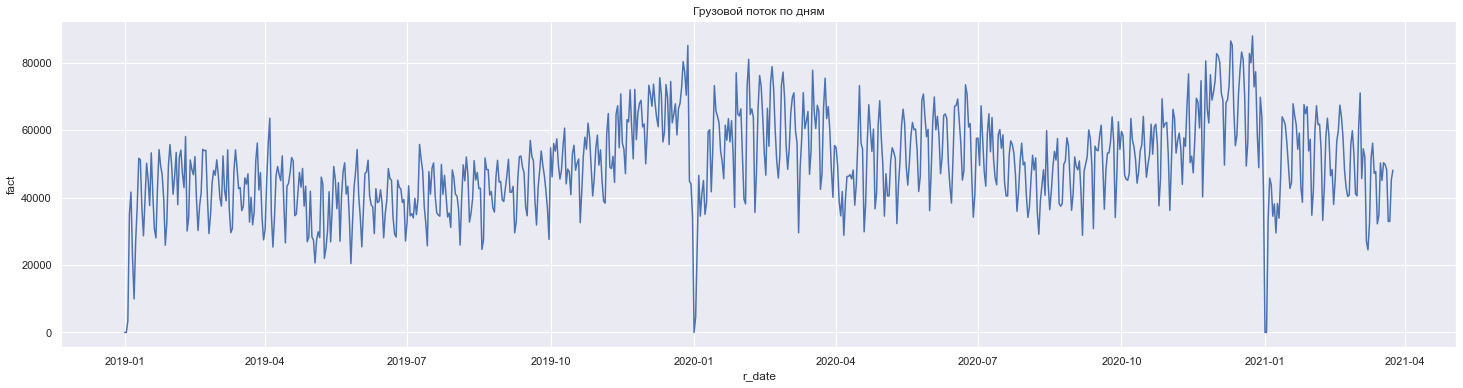

In [74]:
plt.figure(figsize=(25, 6))
sns.lineplot(data=df, x="r_date", y="fact")
plt.title('Грузовой поток по дням')

Добавим несколько признаков

In [79]:
df["year"] = df["r_date"].dt.year # Создаем колонку "Год" из поля "Дата"
df["month"] = df["r_date"].dt.month # Создаем колонку "Месяц"
df["weekday"] = df["r_date"].dt.weekday # Создаем колонку "День недели"

df = pd.get_dummies(df, columns=["year", "month", "weekday"]) # Преобразуем колонки "даты" в бинарные (0/1) колонки

In [75]:
df["mean_week"] = df["fact"].shift(1).rolling(window=7).mean() # среднее за 7 дей
df["mean_month"] = df["fact"].shift(1).rolling(window=30).mean() # среднее за 30 дней

Мы будем пробовать предсказывать данные с конца февраля по март, а именно на 52 дня.
Простая линейная модель имеет один существенный недостаток: необходимо создать такое же количество временных лагов, на которое будет прогноз.  
Таким образом, добавим фактическое значение, равное 52 дням назад.

In [76]:
past_date = 52

for i in range(1, past_date+1):
    df["lag_{}".format(i)] = df.fact.shift(i)

In [77]:
df.dropna(inplace=True) # удаляем пустые строки

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 51 to 813
Data columns (total 77 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   r_date      763 non-null    datetime64[ns]
 1   fact        763 non-null    int64         
 2   mean_week   763 non-null    float64       
 3   mean_month  763 non-null    float64       
 4   lag_1       763 non-null    float64       
 5   lag_2       763 non-null    float64       
 6   lag_3       763 non-null    float64       
 7   lag_4       763 non-null    float64       
 8   lag_5       763 non-null    float64       
 9   lag_6       763 non-null    float64       
 10  lag_7       763 non-null    float64       
 11  lag_8       763 non-null    float64       
 12  lag_9       763 non-null    float64       
 13  lag_10      763 non-null    float64       
 14  lag_11      763 non-null    float64       
 15  lag_12      763 non-null    float64       
 16  lag_13      763 non-null 

In [81]:
df.head(10)

,r_date,fact,mean_week,mean_month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
51,2019-02-21,53947,43172.714286,44870.700000,54333.0,41605.0,37549.0,30263.0,39479.0,52170.0,...,0,0,0,0,0,0,1,0,0,0
52,2019-02-22,54071,44192.285714,45235.933333,53947.0,54333.0,41605.0,37549.0,30263.0,39479.0,...,0,0,0,0,0,0,0,1,0,0
53,2019-02-23,40103,44463.857143,45229.833333,54071.0,53947.0,54333.0,41605.0,37549.0,30263.0,...,0,0,0,0,0,0,0,0,1,0
54,2019-02-24,29341,44553.000000,44916.300000,40103.0,54071.0,53947.0,54333.0,41605.0,37549.0,...,0,0,0,0,0,0,0,0,0,1
55,2019-02-25,34842,44421.285714,44333.300000,29341.0,40103.0,54071.0,53947.0,54333.0,41605.0,...,0,0,0,1,0,0,0,0,0,0
56,2019-02-26,44208,44034.571429,44178.600000,34842.0,29341.0,40103.0,54071.0,53947.0,54333.0,...,0,0,0,0,1,0,0,0,0,0
57,2019-02-27,48104,44406.428571,44789.733333,44208.0,34842.0,29341.0,40103.0,54071.0,53947.0,...,0,0,0,0,0,1,0,0,0,0
58,2019-02-28,46659,43516.571429,45302.100000,48104.0,44208.0,34842.0,29341.0,40103.0,54071.0,...,0,0,0,0,0,0,1,0,0,0
59,2019-03-01,51223,42475.428571,45211.300000,46659.0,48104.0,44208.0,34842.0,29341.0,40103.0,...,0,0,0,0,0,0,0,1,0,0
60,2019-03-02,46627,42068.571429,45060.666667,51223.0,46659.0,48104.0,44208.0,34842.0,29341.0,...,0,0,0,0,0,0,0,0,1,0


Прекрасно, теперь у нас есть датасет с новыми признаками, которые помогут в прогнозе.  
Попробуем построить модели и оценить их качество.